# Test Coffea with a DASK executor

This will test Coffea to see if we can figure out how to use it with our code, but running with a local DASK executor.
This doesn't make sense for this query - there is only one file, but it will test the pipeline!

First are the includes from coffea. This is based on the [example written by Ben](https://github.com/CoffeaTeam/coffea/blob/master/binder/servicex/ATLAS/LocalExample.ipynb).

In [1]:
from servicex import ServiceXDataset
from coffea.processor.servicex import DataSource, Analysis
from coffea.processor.servicex import DaskExecutor 

import matplotlib.pyplot as plt

from coffea import hist, processor
from IPython.display import display, update_display, HTML

And imports connected with running servicex.

In [2]:
from func_adl import ObjectStream
from func_adl_servicex import ServiceXSourceUpROOT
from hist import Hist
import mplhep as mpl
import awkward as ak

from utils import files

Methods copied to help us get all leptons from the source files

In [3]:
def apply_event_cuts (source: ObjectStream) -> ObjectStream:
    '''Event level cuts for the analysis. Keep from sending data that we aren't going to need at all in the end.
    '''
    return (source
        .Where(lambda e: e.trigE or e.trigM))

def good_leptons(source: ObjectStream) -> ObjectStream:
    '''Select out all good leptons from each event. Return their pt, eta, phi, and E, and other
    things needed downstream.

    Because uproot doesn't tie toegher the objects, we can't do any cuts at this point.
    '''
    return source.Select(lambda e:
        {
            'lep_pt': e.lep_pt,
            'lep_eta': e.lep_eta,
            'lep_phi': e.lep_phi,
            'lep_energy': e.lep_E,
            'lep_charge': e.lep_charge,
            'lep_ptcone30': e.lep_ptcone30,
            'lep_etcone20': e.lep_etcone20,
            'lep_type': e.lep_type,
            'lep_trackd0pvunbiased': e.lep_trackd0pvunbiased,
            'lep_tracksigd0pvunbiased': e.lep_tracksigd0pvunbiased,
            'lep_z0': e.lep_z0,
        })

Create the `func_adl` cuts to get the data. The dataset we use here doesn't matter, as long as it "looks" like all the datasets we are going to be processing.

In [4]:
ds = ServiceXSourceUpROOT('cernopendata://dummy',  files['ggH125_ZZ4lep']['treename'], backend_name='dev_uproot')
ds.return_qastle = True
leptons = good_leptons(apply_event_cuts(ds))

The analysis code that will apply the 4 lepton cuts and make the 4 lepton mass plot.

In [5]:
class ATLAS_Higgs_4L(Analysis):
    @staticmethod
    def process(events):
        import awkward as ak
        from collections import defaultdict

        sumw = defaultdict(float)
        mass_hist = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("mass", "$Z_{ee}$ [GeV]", 60, 60, 120),
        )

        dataset = events.metadata['dataset']
        leptons = events.lep

        # We need to look at 4 lepton events only.
        cut = (ak.num(leptons) == 4)

        # Form the invar mass, plot.
        # diele = electrons[cut][:, 0] + electrons[cut][:, 1]
        # diele.mass
        dilepton = leptons[:,0] + leptons[:,1]
        mass_4l = leptons.mass

        # Fill the histogram
        sumw[dataset] += len(events)
        print(len(events))
        mass_hist.fill(
            dataset=dataset,
            mass=ak.flatten(mass_4l),
        )
        
        return {
            "sumw": sumw,
            "mass": mass_hist
        }

Create the data source that we will be running against.

In [6]:
def make_ds(name: str, query: ObjectStream):
    '''Create a ServiceX Datasource for a particular ATLAS Open data file
    '''
    datasets = [ServiceXDataset(files[name]['files'], backend_name='dev_uproot')]
    return DataSource(query=query, metadata={'dataset': name}, datasets=datasets)

And run!

In [7]:
analysis = ATLAS_Higgs_4L()
# TODO: It would be good if datatype was determined automagically (there is enough info)
executor = DaskExecutor()
datasource = make_ds('ggH125_ZZ4lep', leptons)

async def run_updates_stream(accumulator_stream):
  global first

  count = 0
  async for coffea_info in accumulator_stream:
    count += 1
    print(count, coffea_info)
  return coffea_info

# Why do I need run_updates_stream, why not just await on execute (which fails with async gen can't).
# Perhaps something from aiostream can help here?
result = await run_updates_stream(executor.execute(analysis, datasource))

c:\Users\gordo\Code\iris-hep\opendata-higgs-discovery\.venv\lib\site-packages\distributed\node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57039 instead
  warnings.warn(


1 {'sumw': defaultdict(<class 'float'>, {'[root://eospublic.cern.ch//eos/opendata/atlas/OutreachDatasets/2020-01-22/4lep/MC/mc_345060.ggH125_ZZ4lep.4lep.root]': 164716.0}), 'mass': <Hist (dataset,mass) instance at 0x1dd8ee60b20>}


<AxesSubplot:xlabel='$Z_{ee}$ [GeV]', ylabel='Events'>

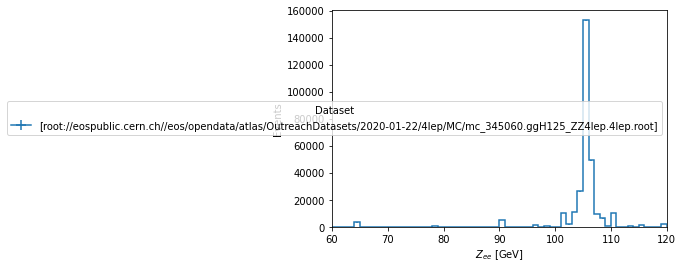

In [8]:
hist.plot1d(result['mass'])